<a href="https://colab.research.google.com/github/1z2s3e4v/dataScience-hw3-Panorama/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%pip install opencv-python==3.4.2.16
%pip install opencv-contrib-python==3.4.2.16
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import random
import time
import math

import imageio
import imutils
from scipy.ndimage.filters import convolve 
from skimage.color import rgb2gray
from numpy import linalg as LA
cv2.ocl.setUseOpenCL(False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     |████████████████████████████████| 25.0MB 2.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 158kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
sift_mode = 'my' # 'cv2' or 'my'

In [3]:
input_folder_list_txt = '/content/drive/MyDrive/other/DataScience/hw3/testfile.txt'

In [4]:
#from scipy.ndimage.filters import gaussian_filter
def gaussian_filter(sigma): 
  size = 2*np.ceil(3*sigma)+1 
  x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1] 
  g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
  return g/g.sum()

def generate_octave(init_level, s, sigma): 
  octave = [init_level] 
  k = 2**(1/s) 
  kernel = gaussian_filter(k * sigma) 
  for _ in range(s+2):
    next_level = convolve(octave[-1], kernel) 
    octave.append(next_level) 
  return octave
def generate_gaussian_pyramid(im, num_octave, s, sigma): 
  pyr = [] 
  for _ in range(num_octave): 
    octave = generate_octave(im, s, sigma) 
    pyr.append(octave) 
    im = octave[-3][::2, ::2] 
  return pyr
def generate_DoG_octave(gaussian_octave): 
  octave = [] 
  for i in range(1, len(gaussian_octave)):   
    octave.append(gaussian_octave[i] - gaussian_octave[i-1]) 
  return np.concatenate([o[:,:,np.newaxis] for o in octave], axis=2) 
def generate_DoG_pyramid(gaussian_pyramid): 
  pyr = [] 
  for gaussian_octave in gaussian_pyramid: 
    pyr.append(generate_DoG_octave(gaussian_octave)) 
  return pyr 
def get_candidate_keypoints(D, w=16): 
  candidates = [] 
  D[:,:,0] = 0 
  D[:,:,-1] = 0 

  for i in range(w//2+1, D.shape[0]-w//2-1): 
    for j in range(w//2+1, D.shape[1]-w//2-1): 
      for k in range(1, D.shape[2]-1): 
        patch = D[i-1:i+2, j-1:j+2, k-1:k+2] 
        if np.argmax(patch) == 13 or np.argmin(patch) ==13: 
          candidates.append([i, j, k]) 
  return candidates
def localize_keypoint(D, x, y, s): 
  dx = (D[y,x+1,s]-D[y,x-1,s])/2. 
  dy = (D[y+1,x,s]-D[y-1,x,s])/2. 
  ds = (D[y,x,s+1]-D[y,x,s-1])/2. 
  dxx = D[y,x+1,s]-2*D[y,x,s]+D[y,x-1,s] 
  dxy = ((D[y+1,x+1,s]-D[y+1,x-1,s]) - (D[y-1,x+1,s]-D[y-1,x-1,s]))/4. 
  dxs = ((D[y,x+1,s+1]-D[y,x-1,s+1]) - (D[y,x+1,s-1]-D[y,x-1,s-1]))/4. 
  dyy = D[y+1,x,s]-2*D[y,x,s]+D[y-1,x,s] 
  dys = ((D[y+1,x,s+1]-D[y-1,x,s+1]) - (D[y+1,x,s-1]-D[y-1,x,s-1]))/4. 
  dss = D[y,x,s+1]-2*D[y,x,s]+D[y,x,s-1] 
  J = np.array([dx, dy, ds]) 
  HD = np.array([ [dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]]) 
  offset = -LA.inv(HD).dot(J)
  return offset, J, HD[:2,:2], x, y, s

def find_keypoints_for_DoG_octave(D, R_th, t_c, w): 
  candidates = get_candidate_keypoints(D, w)
  keypoints = [] 
  for i, cand in enumerate(candidates): 
    y, x, s = cand[0], cand[1], cand[2] 
    offset, J, H, x, y, s = localize_keypoint(D, x, y, s) 
    contrast = D[y,x,s] + .5*J.dot(offset) 
    if abs(contrast) < t_c: continue 
    w, v = LA.eig(H) 
    r = w[1]/w[0] 
    R = (r+1)**2 / r 
    if R > R_th: continue 
    kp = np.array([x, y, s]) + offset
    keypoints.append(kp)

  return np.array(keypoints)

def get_keypoints(DoG_pyr, R_th, t_c, w): 
  kps = [] 
  for D in DoG_pyr: 
    kps.append(find_keypoints_for_DoG_octave(D, R_th, t_c, w)) 
  return kps

def cart_to_polar_grad(dx, dy): 
  m = np.sqrt(dx**2 + dy**2) 
  theta = (np.arctan2(dy, dx)+np.pi) * 180/np.pi 
  return m, theta 

def quantize_orientation(theta, num_bins): 
  bin_width = 360//num_bins 
  return int(np.floor(theta)//bin_width)

def get_local_descriptors(kps, octave, w=16, num_subregion=4, num_bin=8): 
  descs = [] 
  bin_width = 360//num_bin
  for kp in kps:
    cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2]) 
    s = np.clip(s, 0, octave.shape[2]-1) 
    kernel = gaussian_filter(w/6) # gaussian_filter multiplies sigma by 3 
    L = octave[...,s] 
    t, l = max(0, cy-w//2), max(0, cx-w//2) 
    b, r = min(L.shape[0], cy+w//2+1), min(L.shape[1], cx+w//2+1) 
    patch = L[t:b, l:r] 
    if patch.size == 0:
      continue
    dx, dy = get_patch_grads(patch) 
  
    m, theta = cart_to_polar_grad(dx, dy) 
    #dx, dy = dx*kernel, dy*kernel 
    subregion_w = w//num_subregion 
    featvec = np.zeros(num_bin * num_subregion**2, dtype=np.float32) 
    for i in range(0, subregion_w): 
      for j in range(0, subregion_w): 
        t, l = i*subregion_w, j*subregion_w 
        b, r = min(L.shape[0], (i+1)*subregion_w), min(L.shape[1], (j+1)*subregion_w) 
        hist = get_histogram_for_subregion(m[t:b, l:r].ravel(), theta[t:b, l:r].ravel(), num_bin,0, bin_width, subregion_w,i) 
        featvec[i*subregion_w*num_bin + j*num_bin:i*subregion_w*num_bin + (j+1)*num_bin] = hist.flatten() 
    featvec /= max(1e-6, LA.norm(featvec))        
    featvec[featvec>0.2] = 0.2        
    featvec /= max(1e-6, LA.norm(featvec))    
    descs.append(featvec)
  return np.array(descs)
def get_patch_grads(p):

  r1 = np.zeros_like(p) 
  r1[-1] = p[-1] 
  r1[:-1] = p[1:] 
  r2 = np.zeros_like(p) 
  r2[0] = p[0] 
  r2[1:] = p[:-1] 
  dy = r1-r2 
  r1[:,-1] = p[:,-1] 
  r1[:,:-1] = p[:,1:] 
  r2[:,0] = p[:,0] 
  r2[:,1:] = p[:,:-1] 
  dx = r1-r2 
  return dx, dy

def get_histogram_for_subregion(m, theta, num_bin, reference_angle, bin_width, subregion_w,i): 
  hist = np.zeros(num_bin, dtype=np.float32) 
  c = subregion_w/2 - .5
  for mag, angle in zip(m, theta):
    angle = (angle-reference_angle) % 360        
    binno = quantize_orientation(angle, num_bin)        
    vote = mag      
   
    hist_interp_weight = 1 - abs(angle - (binno*bin_width + bin_width/2))/(bin_width/2)        
    vote *= max(hist_interp_weight, 1e-6)         
    gy, gx = np.unravel_index(i, (subregion_w, subregion_w))        
    x_interp_weight = max(1 - abs(gx - c)/c, 1e-6)            
    y_interp_weight = max(1 - abs(gy - c)/c, 1e-6)        
    vote *= x_interp_weight * y_interp_weight         
    hist[binno] += vote
  hist /= max(1e-6, LA.norm(hist)) 
  hist[hist>0.2] = 0.2 
  hist /= max(1e-6, LA.norm(hist))
  return hist

In [5]:
class mySIFT(object):
    
    #use: len(array_of_img) for looping the image, array_of_img[0],
    #array_of_img[1],array_of_img[2],...for processing each image
    #Start SIFT here
    ###sift = cv2.xfeatures2d.SIFT_create()
    ###keypoints, descriptors = sift.detectAndCompute(array_of_img[10], None)
    #End of SIFT here and use imageoutput for your output
    
    ########
    
  def __init__(self, im, s=3, num_octave=4, s0=1.3, sigma=1.6, r_th=10, t_c=0.03, w=16): 
    self.im = convolve(rgb2gray(im), gaussian_filter(s0) )
    self.s = s 
    self.sigma = sigma 
    self.num_octave = num_octave
    self.t_c = t_c 
    self.R_th = (r_th+1)**2 / r_th 
    self.w = w 
  def get_features(self): 
    gaussian_pyr = generate_gaussian_pyramid(self.im, self.num_octave, self.s, self.sigma) 
    DoG_pyr = generate_DoG_pyramid(gaussian_pyr) 
    kp_pyr = get_keypoints(DoG_pyr, self.R_th, self.t_c, self.w) 
    feats = [] 
    
    for i, DoG_octave in enumerate(DoG_pyr): 
      #kp_pyr[i] = assign_orientation(kp_pyr[i], DoG_octave) 
      feats.append(get_local_descriptors(kp_pyr[i], DoG_octave)) 
    self.kp_pyr = kp_pyr 
    self.feats = feats 
    #change keytype
    key = []
    for i in range(0,len(kp_pyr)):
      for j in range(0,len(kp_pyr[i])):
        tmp=cv2.KeyPoint(kp_pyr[i][j][0],kp_pyr[i][j][1],kp_pyr[i][j][2])
        key.append(tmp)
    #change feats type
    featss = []
    for i in range(0,len(feats)):
      for j in range(0,len(feats[i])):
          featss.append(feats[i][j])
    return key,np.array(featss)

# Stitch

In [6]:
def detectAndDescribe(image):
    """
    Compute key points and feature descriptors using an specific method
    """
    if sift_mode == 'cv2':
        descriptor = cv2.xfeatures2d.SIFT_create()
        (keys, feats) = descriptor.detectAndCompute(image, None)
        return (keys, feats)
    elif sift_mode == 'my':
        s_c = mySIFT(image)
        keys, feats = s_c.get_features()
        return (keys, feats)
    #print("kps ", type(kps), type(kps[0]))
    #print("feature", type(features), features.shape)

In [7]:
def matchKeyPointsKNN(featuresA, featuresB, ratio):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [8]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,reprojThresh)

        return (matches, H, status)
    else:
        return None

In [9]:
def cylindricalWarp(img,Cylindrical_F):
    """This function returns the cylindrical warp for a given image"""
    h_,w_ = img.shape[:2]
    K = np.array([[Cylindrical_F,0,w_/2],[0,Cylindrical_F,h_/2],[0,0,1]]) # mock intrinsics
    # pixel coordinates
    y_i, x_i = np.indices((h_,w_))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3) # to homog
    Kinv = np.linalg.inv(K) 
    X = Kinv.dot(X.T).T # normalized coords
    # calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    B = K.dot(A.T).T # project back to image-pixels plane
    # back from homog coords
    B = B[:,:-1] / B[:,[-1]]
    # make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    
    img_rgba = img
    #img_rgba = cv2.cvtColor(img,cv2.COLOR_BGR2BGRA) # for transparent borders...
    # warp the image according to cylindrical coords
    return cv2.remap(img_rgba, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA)

In [10]:
def blend_stitching(img_left,result):
    # find the left image and right image mask regio
    (hl, wl) = img_left.shape[:2]
    overlap_start_end = np.full((hl, 2), np.array([800, 0]))
    for i in range(hl):
        for j in range(wl):
            if np.count_nonzero(img_left[i, j]) > 0:
                overlap_start_end[i][1] = max(overlap_start_end[i][1],j)
            if np.count_nonzero(result[i, j]) > 0:
                overlap_start_end[i][0] = min(overlap_start_end[i][0],j)

    # stitching
    for y in range(img_left.shape[0]):
        for x in range(img_left.shape[1]):
            if np.count_nonzero(img_left[y, x]) > 0 and np.count_nonzero(result[y, x]) > 0:
                w = overlap_start_end[y][1] - overlap_start_end[y][0]
                result[y][x] = img_left[y][x]*np.full(img_left.shape[2], (overlap_start_end[y][1]-x)/w) + result[y][x]*np.full(result.shape[2], (x-overlap_start_end[y][0])/w)
            elif np.count_nonzero(img_left[y, x]) > 0:
                result[y][x] = img_left[y][x]
    return result

In [11]:
def removeBlackBorder(img):
    # transform the panorama image to grayscale and threshold it 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
    # Finds contours from the binary image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # get the maximum contour area
    c = max(cnts, key=cv2.contourArea)
    # get a bbox from the contour area
    (x, y, w, h) = cv2.boundingRect(c)
    # crop the image to the bbox coordinates
    img = img[y:y + h, x:x + w]
    return img

In [12]:
def stitch(img_left,img_right,reverse=0):
    if reverse == 0:
        img_left_masked = np.array(img_left, copy=True)
        for i in range(0,img_left_masked.shape[0]):
            for j in range(0,img_left.shape[1]-img_right.shape[1]):
                img_left_masked[i][j]=0
        img_right_masked = np.array(img_right, copy=True)
        for i in range(0,img_right_masked.shape[0]):
            for j in range(img_right_masked.shape[1]//2,img_right_masked.shape[1]):
                img_right_masked[i][j]=0

        ## get kry points and features with sitf
        print("sift start...")
        t0 = time.clock()
        kpsA, featuresA = detectAndDescribe(img_right_masked) # Transfor
        kpsB, featuresB = detectAndDescribe(img_left_masked) # Query 
        print("sift end! time =", time.clock()-t0, "sec")
        print("key points: (left, right) =",len(kpsB),len(kpsA))
        
        ## draw matching image
        fig = plt.figure(figsize=(20,8))
        matches = matchKeyPointsKNN(featuresB, featuresA, ratio=0.75)
        img3 = cv2.drawMatches(img_left,kpsB,img_right,kpsA,np.random.choice(matches,100),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) 
        plt.imshow(img3)
        plt.show()
        ## get real matches
        matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75)
        
        ## homography
        M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
        if M is None: 
            print("Error!")
            return img_left, False
        (matches, H, status) = M

        ## Apply panorama correction and stitch
        width = img_right.shape[1] + img_left.shape[1]
        height = img_right.shape[0] + img_left.shape[0]
        result = cv2.warpPerspective(img_right, H, (width, height))
        result = blend_stitching(img_left,result)

    elif reverse == 1:
        img_left = cv2.flip(img_left, 1)
        img_right = cv2.flip(img_right, 1)

        img_left_masked = np.array(img_left, copy=True)
        for i in range(0,img_left_masked.shape[0]):
            for j in range(img_right.shape[1],img_left_masked.shape[1]):
                img_left_masked[i][j]=0
        img_right_masked = np.array(img_right, copy=True)
        for i in range(0,img_right_masked.shape[0]):
            for j in range(0,img_right_masked.shape[1]//2):
                img_right_masked[i][j]=0

        ## get kry points and features with sitf
        print("sift start...")
        t0 = time.clock()
        kpsA, featuresA = detectAndDescribe(img_left_masked) # Transfor
        kpsB, featuresB = detectAndDescribe(img_right_masked) # Query 
        print("sift end! time =", time.clock()-t0, "sec")
        print("key points: (left, right) =",len(kpsB),len(kpsA))
        
        ## draw matching image
        fig = plt.figure(figsize=(20,8))
        matches = matchKeyPointsKNN(featuresB, featuresA, ratio=0.75)
        img3 = cv2.drawMatches(img_right,kpsB,img_left,kpsA,np.random.choice(matches,100),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) 
        plt.imshow(cv2.flip(img3,1))
        plt.show()
        ## get real matches
        matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75)
        
        ## homography
        M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
        if M is None: 
            print("Error!")
            return img_left, False
        (matches, H, status) = M

        ## Apply panorama correction and stitch
        width = img_right.shape[1] + img_left.shape[1]
        height = img_right.shape[0] + img_left.shape[0]
        result = cv2.warpPerspective(img_left, H, (width, height))
        result = blend_stitching(img_right,result)
        result = cv2.flip(result,1)

    ## remove black border
    result = removeBlackBorder(result)
    return result, True

In [13]:
array_of_img = [] # Store all the image data
# Read directory function
def read_directory(directory_name):
    filenumber = len([name for name in os.listdir(directory_name) if os.path.isfile(os.path.join(directory_name, name))])
    for i in range(1,filenumber+1):
        img = cv2.imread(directory_name + "/" + str(i)+".jpg")
        array_of_img.append(img)
                         
def SIFT(inputname):
    array_of_img.clear()
    read_directory(inputname)
    #use: len(array_of_img) for looping the image, array_of_img[0],
    #array_of_img[1],array_of_img[2],...for processing each image
    #Start SIFT here
    print("img_num = " + str(len(array_of_img)))
    #Cylindrical_F = 800
    #### resize if image is too big
    for i in range(0,len(array_of_img)):
        height, width, channels = array_of_img[i].shape
        if height > 800 :
            array_of_img[i] = cv2.resize(array_of_img[i], (int(width/10),int(height/10)), interpolation=cv2.INTER_CUBIC)
        #array_of_img[i] = cylindricalWarp(array_of_img[i],Cylindrical_F)
    #### resize end
    #### Start of Panorama
    #array_of_img[0] = cylindricalWarp(array_of_img[0],Cylindrical_F)
    for i in range(1,len(array_of_img)//2):
        ## get images
        print("Stitching pic",i)
        img_left = cv2.normalize(array_of_img[0], None, 0, 255, cv2.NORM_MINMAX).astype('uint8') # make image legal
        img_right = cv2.normalize(array_of_img[i], None, 0, 255, cv2.NORM_MINMAX).astype('uint8') # make image legal
        #img_right = cylindricalWarp(img_right,Cylindrical_F)
        array_of_img[0], success = stitch(img_left,img_right,1)
        if not success:
            return array_of_img[0]
        #Cylindrical_F += 200 / len(array_of_img)//2
    #Cylindrical_F = 800
    #array_of_img[len(array_of_img)//2] = cylindricalWarp(array_of_img[len(array_of_img)//2],Cylindrical_F)
    for i in range(len(array_of_img)//2+1,len(array_of_img)):
        ## get images
        print("Stitching pic",i)
        img_left = cv2.normalize(array_of_img[len(array_of_img)//2], None, 0, 255, cv2.NORM_MINMAX).astype('uint8') # make image legal
        img_right = cv2.normalize(array_of_img[i], None, 0, 255, cv2.NORM_MINMAX).astype('uint8') # make image legal
        #img_right = cylindricalWarp(img_right,Cylindrical_F)
        array_of_img[len(array_of_img)//2], success = stitch(img_left,img_right,0)
        if not success:
            return array_of_img[0]
        #Cylindrical_F += 200 / len(array_of_img)//2
    
    print("Stitching left and right part.")
    img_left = cv2.normalize(array_of_img[0], None, 0, 255, cv2.NORM_MINMAX).astype('uint8') # make image legal
    img_right = cv2.normalize(array_of_img[len(array_of_img)//2], None, 0, 255, cv2.NORM_MINMAX).astype('uint8') # make image legal
    array_of_img[0] = stitch(img_left,img_right,0)
    #### End of Panorama

    #End of SIFT here and use imageoutput for your output
    imageoutput = array_of_img[0]
    return imageoutput

# Main

In [14]:
def run_main(file_txt):
  f = open(file_txt, 'r')
  #dirname = str(f.readline()).strip()
  dirname = str(f.readline()).strip()
  while(dirname):
      print("\nimage folder: "+dirname)
      imageout=SIFT(dirname)
      plt.figure()
      plt.imshow(imageout)
      cv2.imwrite(dirname+'.jpg', imageout)
      dirname = str(f.readline()).strip()


image folder: /content/drive/MyDrive/other/DataScience/hw3/pano
img_num = 7
Stitching pic 1
sift start...
sift end! time = 14.531451 sec
key points: (left, right) = 49 60
Raw matches (knn): 49


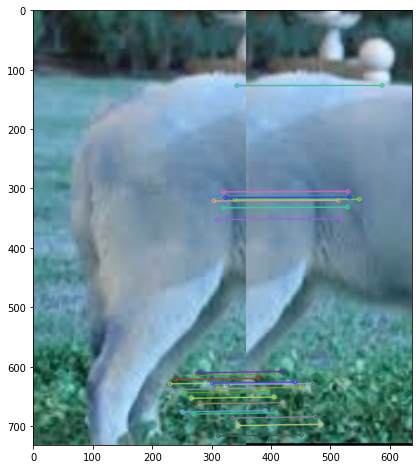

Raw matches (knn): 60


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


Stitching pic 2
sift start...
sift end! time = 15.977119000000002 sec
key points: (left, right) = 36 57
Raw matches (knn): 36


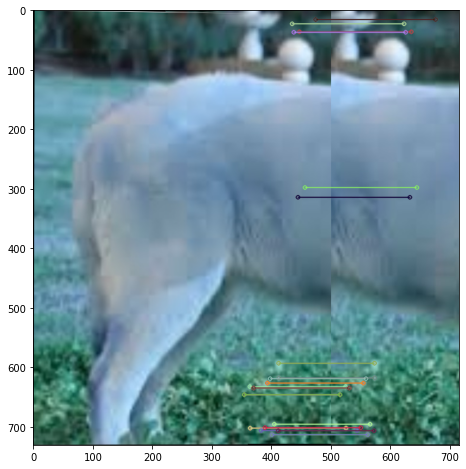

Raw matches (knn): 57
Stitching pic 4
sift start...
sift end! time = 9.878536000000004 sec
key points: (left, right) = 50 39
Raw matches (knn): 50


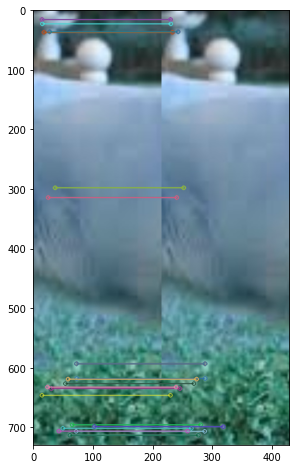

Raw matches (knn): 39
Stitching pic 5
sift start...
sift end! time = 9.826882999999995 sec
key points: (left, right) = 50 39
Raw matches (knn): 50


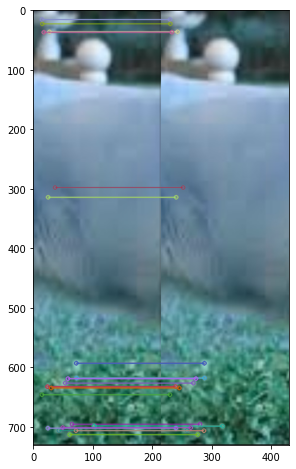

Raw matches (knn): 39
Stitching pic 6
sift start...
sift end! time = 18.631726 sec
key points: (left, right) = 51 79
Raw matches (knn): 51


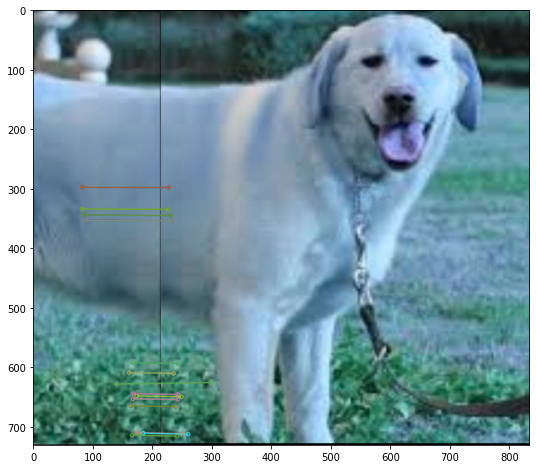

Raw matches (knn): 79
Stitching left and right part.
sift start...
sift end! time = 28.549890000000005 sec
key points: (left, right) = 113 95
Raw matches (knn): 113


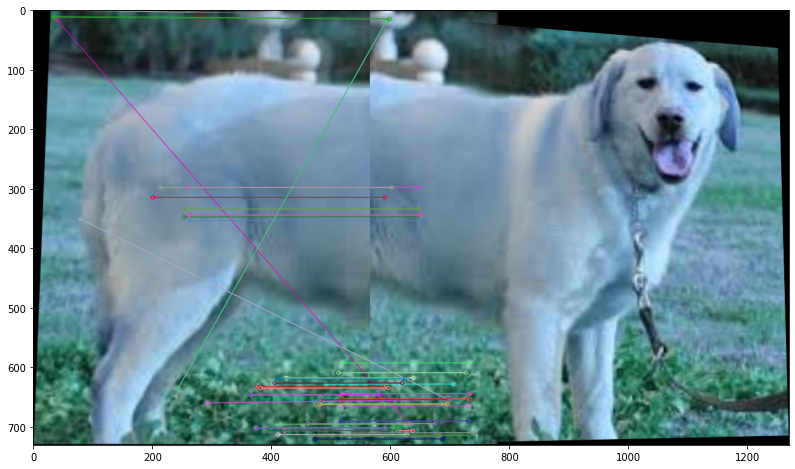

Raw matches (knn): 95


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:706: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = np.array(x, subok=True, copy=copy)


TypeError: ignored

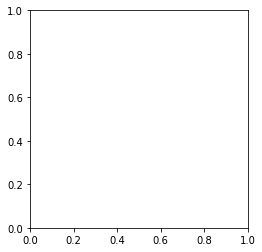

In [15]:
run_main(input_folder_list_txt)